# Raster2: Projection, clipping, sampling, zonal stats
## Featuring the best<sup>*</sup> raster of all: DEMs

UW Geospatial Data Analysis  
CEE498/CEWA599  
David Shean  

<sup>*</sup>An objective conclusion

## What is a DEM?
DEM = Digital Elevation Model

A generic term for a 2D raster grid with values representing surface elevation above some datum (e.g., WGS84 ellispoid or a geoid model representing mean sea level).

There are subtypes:
* DSM = Digital Surface Model ("first-return" model includes top of canopy, buildings, etc.)
* DTM = Digital Terrain Model (bare ground model, with canopy, buildings, etc. removed)

## Airborne LiDAR example
* https://lidarportal.dnr.wa.gov/

## SRTM
SRTM = Shuttle Radar Topography Mission  
https://en.wikipedia.org/wiki/Shuttle_Radar_Topography_Mission
https://www2.jpl.nasa.gov/srtm/

This week, we'll play with the landmark SRTM dataset.  We briefly introduced this during Lab03, as I sampled the SRTM products for the GLAS point locations and included as the `dem_z` column in the csv.
* Collected February 11-22, 2000 (winter)
* Single-track InSAR (interferometric synthetic aperture radar) instrument
* Coverage: 56°S to 60°N (the shuttle orbit)
* Tiled in 1x1° raster data at different resolutions: 
    * 1-arcsecond (~30 m)
    * 3-arcsecond (~90 m)
* Default elevation values in the SRTM tiles are relative to the EGM96 geoid (approximates mean sea level), not the WGS84 ellipsoid (as with the GLAS points)

For this lab, we'll use the 3-arcsec (90 m) SRTM product for WA state to learn some new concepts.  This is a relatively small dataset, with only two 1x1° tiles required.  However, the approaches we'll learn (e.g., using vrt datasets), scale to larger datasets that are too big to fit in memory (like operations on the global SRTM dataset).  In future weeks, we'll explore xarray, which can also be used to efficiently process raster data (and raster time series).

# Interactive discussion topics
* Mixing command line utilities and Python API code
* vrt
* raster reprojection
* interpolation - nearest neighbor vs bilinear
* UTM false easting, false northing
* DEM derivative products: shaded relief, slope, aspect
* area vs. volume calculation
* sampling at points
* zonal statistics

# Resources
* https://pysal.org/scipy2019-intermediate-gds/deterministic/gds2-rasters.html

# Interactive Demo

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import rasterstats

In [2]:
from matplotlib_scalebar.scalebar import ScaleBar

In [3]:
%matplotlib inline

# Download sample SRTM data for WA state

## Define the Washington state bounds from previous notebook
* Use the lat/lon bounds here in decimal degrees

In [4]:
wa_bounds = (-124.733174, 45.543541, -116.915989, 49.002494)

## Use the `elevation` package to download and prepare appropriate tiles
* We could do this ourselves, but let's use a helper package to simplify the process
    * https://github.com/bopen/elevation
    * Note that this package is already a bit outdated, but it still works

In [5]:
#Install the elevation package
!pip install elevation

  Using cached https://files.pythonhosted.org/packages/b8/9a/e55570fa28fbe3106da6ac9a5df0156c39647551171e10de45624069a917/elevation-1.0.6-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/34/c1/8806f99713ddb993c5366c362b2f908f18269f8d792aff1abfd700775a77/click-6.7-py2.py3-none-any.whl
Processing /home/jovyan/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e/future-0.18.2-cp37-none-any.whl
  Found existing installation: Click 7.0
    Uninstalling Click-7.0:
      Successfully uninstalled Click-7.0


In [6]:
import elevation

In [7]:
#Set some variables for the SRTM download
cache_dir='./elevation'
#We'll use the 3-arcsec products 
product='SRTM3'
#Higher-res 1-arcsec products
#product='SRTM1'
output='wa_%s_full.tif' % product

## Download the tiles that intersect WA bounds
* This will take a few minutes to download relevant tiles and process
* While you wait, open a terminal and navigate to the `elevation/SRTM3/cache` subdirectory in same directory as your notebook.
    * This is where the two tif files that intersect the WA extent will be cached (each ~25-30 MB)
    * Run `gdalinfo` on one of the tif files
        * Note image size in pixels, the coordinate system, and the corner coordinates
* Note that the `elevation` module also has a `clip` function to clip to specified bounds, but we're going to learn how to do this ourselves, as it's a common operation

In [8]:
#elevation.clean(cache_dir=cache_dir)
elevation.seed(bounds=wa_bounds, cache_dir=cache_dir, product=product, max_download_tiles=999)
#elevation.clip(bounds=wa_bounds, output=output, cache_dir=cache_dir, product=product, max_download_tiles=999)

'./elevation/SRTM3'

In [9]:
#Check the downloaded products in the cache subdirectory
!ls -lh $cache_dir/$product/cache

total 53M
-rw-rw-r-- 1 jovyan users 25M Feb 25 19:01 srtm_12_03.tif
-rw-rw-r-- 1 jovyan users   0 Feb 25 18:59 srtm_12_03.tif.lock
-rw-rw-r-- 1 jovyan users 29M Feb 25 19:02 srtm_13_03.tif
-rw-rw-r-- 1 jovyan users   0 Feb 25 18:59 srtm_13_03.tif.lock


In [10]:
#Inspect the geotiff header
!gdalinfo $cache_dir/$product/cache/srtm_12_03.tif

Driver: GTiff/GeoTIFF
Files: ./elevation/SRTM3/cache/srtm_12_03.tif
Size is 6000, 6000
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-125.000000000000000,50.000000000000000)
Pixel Size = (0.000833333333333,-0.000833333333333)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=DEFLATE
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-125.0000000,  50.0000000) (125d 0' 0.00"W, 50d 0' 0.00"N)
Lower Left  (-125.0000000,  45.0000000) (125d 0' 0.00"W, 4

## Create a vrt (virtual file) mosaic of the tif files
* Read a bit about vrt (they're a little confusing/abstract, but once you get the concept, they're amazing): 
    * https://www.gdal.org/gdal_vrttut.html
    * http://www.perrygeo.com/lazy-raster-processing-with-gdal-vrts.html
* Can do this with API, but it's easy to use the `gdalbuildvrt` command-line utility for this: https://www.gdal.org/gdalbuildvrt.html

In [11]:
vrt_fn = '%s_wa_mosaic.vrt' % product
!gdalbuildvrt -r cubic $vrt_fn $cache_dir/$product/cache/*.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


## Discussion: Review the contents of the output vrt file
* Use shell command `cat` from a notebook cell and the `vrt_fn` variable (hopefully this is routine by now)
* This is not json, not markdown, but yet another text format: xml
* Note the total width and height of the vrt (rasterXSize, rasterYSize). 
    * How does this compare with the width and height of the individual tile from the `gdalinfo` output above?  
* Note the `DstRect` values (destinatioin rectangle) for each tile.  Take a moment to discuss with your neighbor.  How is each tile placed within the vrt?  
    * What would the values be for the next two tiles from the row to the south?

In [12]:
!cat $vrt_fn

<VRTDataset rasterXSize="12000" rasterYSize="6000">
  <SRS dataAxisToSRSAxisMapping="2,1">GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]</SRS>
  <GeoTransform> -1.2500000000000000e+02,  8.3333333333333339e-04,  0.0000000000000000e+00,  5.0000000000000000e+01,  0.0000000000000000e+00, -8.3333333333333339e-04</GeoTransform>
  <VRTRasterBand dataType="Int16" band="1">
    <NoDataValue>-32768</NoDataValue>
    <ColorInterp>Gray</ColorInterp>
    <ComplexSource resampling="cubic">
      <SourceFilename relativeToVRT="1">./elevation/SRTM3/cache/srtm_12_03.tif</SourceFilename>
      <SourceBand>1</SourceBand>
      <SourceProperties RasterXSize="6000" RasterYSize="6000" DataType="Int16" BlockXSize="256" BlockYSize="256" />
      <SrcRect xOff="0" yOff="0" xSize="600

## Open the vrt with rasterio
* Note that rasterio and GDAL can open vrt files as dataset objects (similar to a GeoTiff)!  This is very useful, as you could have a vrt containing SRTM tiles for the entire planet, and open it in seconds, since you're not actually reading each file, just the vrt "container" that points to all of the individual tif files
    * You can then read only the raster subwindow that you need for analysis as a NumPy array
        * We did this with the Landsat-8 window over Mt. Rainier
    * The subwindow can cross multiple tiles, and GDAL does the work behind the scenes

In [13]:
src = rio.open(vrt_fn)

## Review the metadata
* Note the input data type - is this signed (meaning values can be positive or negative)?

In [14]:
src.profile

{'driver': 'VRT', 'dtype': 'int16', 'nodata': -32768.0, 'width': 12000, 'height': 6000, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0008333333333333334, 0.0, -125.0,
       0.0, -0.0008333333333333334, 50.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True}

## Plot using `rio.plot.show()`
* Use the `with` construct here to cleanly open and close the `vrt` file, with better handling of any exceptions

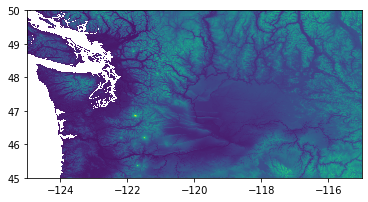

In [15]:
with rio.open(vrt_fn) as src:
    rio.plot.show(src)

## Read the data and plot with matplotlib
* Read the data to a NumPy array
    * Note that the tiles on disk are not actually loaded until you `read` the dataset
    * Make sure you deal with nodata, either with a NumPy masked array, or setting nodata to np.nan (remember np.nan is a float, your input data type is int16)
* View with matplotlib imshow - verify you have a DEM of washington state

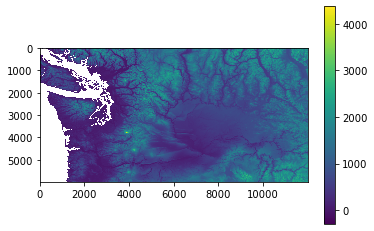

In [16]:
with rio.open(vrt_fn) as src:
    f, ax = plt.subplots()
    srtm = np.ma.masked_equal(src.read(1), src.nodata)
    m = ax.imshow(srtm)
    plt.colorbar(m)

## Reproject the SRTM vrt to UTM 10N
* The SRTM grids are distributed with crs of EPSG:4326
* Let's reproject to a more appropriate coordinate system for WA state
    * Use EPSG:32610

### First, reproject using `gdalwarp` command-line utility
* A very simple, efficient way to accomplish this - let GDAL worry about all of the underlying math
* Review the documentation and options here: https://gdal.org/programs/gdalwarp.html
* Save the projected file as a GeoTiff on disk
    * Use `cubic` resampling algorithm
* Note the filesize using `ls -lh`

In [17]:
proj_fn = os.path.splitext(vrt_fn)[0]+'_utm_gdalwarp.tif'

In [18]:
if not os.path.exists(proj_fn):
    !gdalwarp -r cubic -t_srs EPSG:32610 $vrt_fn $proj_fn

In [19]:
ls -lh $proj_fn

-rw-rw-r-- 1 jovyan users 182M Feb 25 19:03 SRTM3_wa_mosaic_utm_gdalwarp.tif


## A note about "creation options" when writing a new file to disk
* Review this great reference on GeoTiff file format: https://www.gdal.org/frmt_gtiff.html
    * See Creation Options section toward bottom of page: https://gdal.org/drivers/raster/gtiff.html#creation-options
* I almost always use `-co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER`
    * Uses lossless LZW compression (we explored in LS8 example comparing filesize on disk to your calculated array filesize)
    * Writes the tif image in "tiles" of 256x256 px instead of one large block - makes it much more efficient to read and extract a subwindow from the tif
    * If necessary, use the BIGTIFF format for files that are >4 GB

## Write out the same file, but this time use tiling and LZW compression
* Compare the new filesize on disk

In [20]:
proj_fn_lzw = os.path.splitext(vrt_fn)[0]+'_utm_gdalwarp_lzw.tif'

In [21]:
if not os.path.exists(proj_fn_lzw):
    !gdalwarp -r cubic -t_srs EPSG:32610 -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER $vrt_fn $proj_fn_lzw

In [22]:
ls -lh $proj_fn_lzw

-rw-rw-r-- 1 jovyan users 110M Feb 25 19:03 SRTM3_wa_mosaic_utm_gdalwarp_lzw.tif


In [23]:
#Let's use the compressed file from here on out
#Should compare runtimes when using compressed vs. uncompressed
proj_fn = proj_fn_lzw

## Now try using rasterio to reproject
* This is still surprisingly complicated compared to the GeoPandas `to_crs` method
    * But if you look at what's actually happening, it's not too bad
* See example here: https://rasterio.readthedocs.io/en/stable/topics/reproject.html#reprojecting-a-geotiff-dataset
* Define your coordinate system as `dst_crs` variable (needed later)
* Save the projected file as a GeoTiff on disk
    * print the metadata of your input and output datasets
    * If you are copying the metadata from your input vrt dataset (as in the rasterio doc example), you will need to update the 'driver' to 'GTiff' before open the file for writing
    * Use cubic resampling algorithm
* You can specify these configuration options in the `rasterio.open()` kwargs:
    * https://github.com/mapbox/rasterio/blob/master/docs/topics/image_options.rst
    * https://rasterio.readthedocs.io/en/stable/topics/profiles.html
    * https://rasterio.readthedocs.io/en/stable/topics/configuration.html
* Note that it is also possible to reproject and store the resulting dataset in memory, rather than writing to disk
    * This is desirable if you need to temporarily reproject a raster dataset, read the array, do some analysis

In [24]:
def rio_reproj_write(src, proj_fn, dst_crs, driver='GTiff'):
    #Check to see if output filename already exists
    if os.path.exists(proj_fn):
        print("File exists: ", proj_fn)
    else:
        #Get the required transformation and output width and height
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        #Create a copy of input metadata, then update with output values
        kwargs = src.meta.copy()
        print("Source metadata:\n", kwargs)
        kwargs.update({'crs':dst_crs,'transform':transform,'width':width,'height':height})
        kwargs['driver'] = driver
        #Set output creation options
        kwargs['compress'] = 'LZW'
        kwargs['tiled'] = True
        kwargs['BIGTIFF'] = 'IF_SAFER'
        print("Destination metadata:\n", kwargs)

        #Open the destination dataset in write mode
        with rio.open(proj_fn, 'w', **kwargs) as dst:
            print("Writing: ", proj_fn)
            #Loop through each input band
            for i in range(1, src.count + 1):
                #Reproject!
                reproject(source=rio.band(src, i), destination=rio.band(dst, i), src_transform=src.transform,\
                          src_crs=src.crs, dst_transform=transform, dst_crs=dst_crs, resampling=Resampling.cubic)        

In [25]:
dst_crs = 'EPSG:32610'

In [26]:
src = rio.open(vrt_fn)
proj_fn = os.path.splitext(vrt_fn)[0]+'_utm_riowarp.tif'
rio_reproj_write(src, proj_fn, dst_crs)

File exists:  SRTM3_wa_mosaic_utm_riowarp.tif


## Load your reprojected dataset as an array and plot

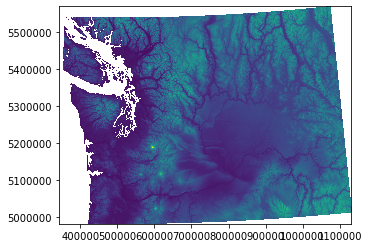

In [27]:
with rio.open(proj_fn) as src_proj:
    rio.plot.show(src_proj)

In [28]:
src_proj = rio.open(proj_fn)

In [29]:
src_proj.profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 11298, 'height': 8406, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(69.75777310180744, 0.0, 342369.35927004984,
       0.0, -69.75777310180744, 5569366.822198175), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [30]:
#Load as float array with np.nan values
#srtm_proj = src_proj.read(1).astype(float)
#srtm_proj[srtm_proj==src_proj.nodata] = np.nan
#Load as a masked array
srtm_proj = np.ma.masked_equal(src_proj.read(1), src_proj.nodata)

In [31]:
srtm_proj.shape

(8406, 11298)

## Discussion Questions
* What is the projected x and y cell size (output resolution)?
* Is this consistent with your expectation for the 3-arcsec SRTM data?
    * Hint: Think about the dimensions of a pixel in meters near the top and bottom of the input SRTM grid. Then think back to Lab04 when we calculated length of a degree of longitude and a degree of latitude at different locations on the planet.
    * Info on an arcsecond: https://www.esri.com/news/arcuser/0400/wdside.html
* Note that if the output resolution is unspecified, GDAL and rasterio will estimate for you.  But you can also specify this output resolution (`-tr` argument in `gdalwarp`), if, for example, you wanted to resample your output to 180 m resolution.

In [32]:
src_proj.transform

Affine(69.75777310180744, 0.0, 342369.35927004984,
       0.0, -69.75777310180744, 5569366.822198175)

In [33]:
src_proj.res

(69.75777310180744, 69.75777310180744)

## Create a shaded relief map (hillshade) from your projected DEM
* See background info on hillshades (and other DEM derivative products like slope and aspect) here: http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-hillshade-works.htm
* Can do this easily with `gdaldem` command line utility: https://www.gdal.org/gdaldem.html
    * Try this and output to a new file
    * Note that if you were to run on a DEM with different horizontal and vertical units, (like say, degrees and meters), you will have scaling issues. There are ways around this, but Always generate hillshade using a projected DEM.

In [34]:
hs_fn = os.path.splitext(proj_fn)[0]+'_hs.tif'

In [35]:
if not os.path.exists(hs_fn):
    !gdaldem hillshade $proj_fn $hs_fn

* Can also use GDAL Python API directly
    * Documentation of this functionality is poor, but it's pretty simple (see my example below)
    * Some examples are here: https://github.com/OSGeo/gdal/blob/master/autotest/utilities/test_gdaldem_lib.py

### Example using GDAL API

In [36]:
def gdal_hs_ds(fn):
    from osgeo import gdal
    #Open the GDAL dataset
    dem_ds = gdal.Open(fn)
    #Specify the type of product we want (e.g., hillshade, slope, aspect) - see gdaldem doc for list of avaiable options
    producttype = 'hillshade'
    #Create a GDAL hillshade dataset in memory
    hs_ds = gdal.DEMProcessing('', dem_ds, 'hillshade', format='MEM')
    return hs_ds

def gdal_hs_ma(fn):
    #Get GDAL Dataset
    hs_ds = gdal_hs_ds(fn)
    #Read the dataset as a NumPy array
    hs = hs_ds.ReadAsArray()
    return hs

In [37]:
#Create hillshade from a filename
#hs_ma = gdal_hs_ma(fn)
#plt.imshow(hs_ma, cmap='gray')

### Work in progress: dynamically create shaded relief, slope and aspect using numpy

In [38]:
#Function to return hillshade (for visualization), slope magnitude (deg) and aspect on the fly
#This is a work in progress, aspect values are incorrect!
def hillshade(a, res=1.0, sun_az=315, sun_el=45):
    sun_az = 360.0 - sun_az
    dx, dy = np.gradient(a, res)
    slope = np.pi/2. - np.arctan(np.sqrt(dx*dx + dy*dy))
    aspect = np.arctan2(-dx, dy)
    shaded = np.sin(np.radians(sun_az)) * np.sin(slope) + \
    np.cos(np.radians(sun_el)) * np.cos(slope) * \
    np.cos((np.radians(sun_az) - np.pi/2.) - aspect)
    hs = 255 * (shaded + 1)/2
    return hs, np.degrees(np.pi/2. - slope), np.degrees(aspect)

## Load your shaded relief map as a new NumPy masked array 
* Note that the datatype is 8-bit (Byte), with values from 0-255 (it's a grayscale image, not elevation data)
* Make sure you mask nodata values

In [39]:
hs_src = rio.open(hs_fn)
hs = np.ma.masked_equal(hs_src.read(1), hs_src.nodata)

## Get the extent of the hillshade dataset in the projected coordinate system
* See `rio.plot.plotting_extent`
* Pass this to imshow `extent` and verify that your coordinates look good

In [40]:
hs_extent = rio.plot.plotting_extent(hs_src)
hs_extent

(342369.35927004984, 1130492.6797742704, 4982982.981504382, 5569366.822198175)

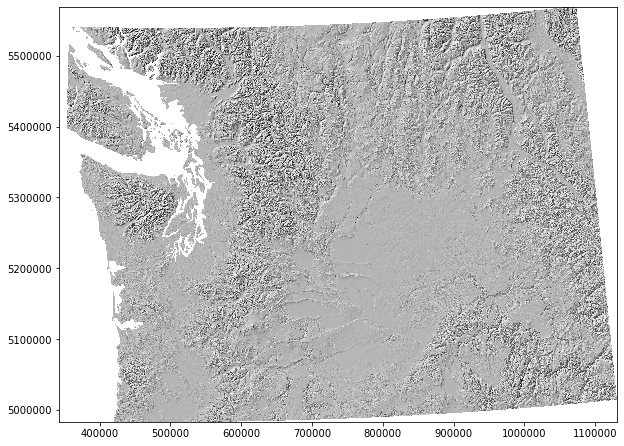

In [41]:
f, ax = plt.subplots(figsize=(10,10))
ax.imshow(hs, cmap='gray', extent=hs_extent);

## Load the states GeoDataFrame

In [42]:
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)
states_gdf.head()

GEO_ID STATE           NAME LSAD  CENSUSAREA  \
0  0400000US23    23          Maine        30842.923   
1  0400000US25    25  Massachusetts         7800.058   
2  0400000US26    26       Michigan        56538.901   
3  0400000US30    30        Montana       145545.801   
4  0400000US32    32         Nevada       109781.180   

                                            geometry  
0  MULTIPOLYGON (((-67.61976 44.51975, -67.61541 ...  
1  MULTIPOLYGON (((-70.83204 41.60650, -70.82373 ...  
2  MULTIPOLYGON (((-88.68443 48.11579, -88.67563 ...  
3  POLYGON ((-104.05770 44.99743, -104.25015 44.9...  
4  POLYGON ((-114.05060 37.00040, -114.04999 36.9...

## Reproject the GeoDataFrame to match your DEM

In [43]:
states_gdf_proj = states_gdf.to_crs(dst_crs)

/srv/conda/envs/notebook/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


## Isolate the WA state geometry object
* We want the geometry, not a GeoDataFrame or GeoSeries

In [44]:
wa_state = states_gdf_proj.loc[states_gdf_proj['NAME'] == 'Washington']
wa_geom = wa_state.iloc[0].geometry

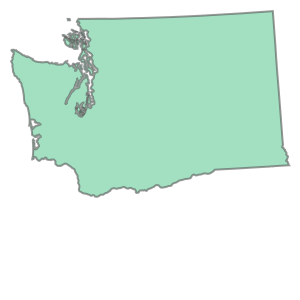

In [45]:
wa_geom

## Clip your projected DEM dataset (not the hillshade) to the WA state multipolygon
* This is a common GIS operation
* Some useful resources:
    * https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html
    * https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html
    * https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/crop-raster-data-with-shapefile-in-python/
* Note that input for rasterio `mask` is a rasterio dataset, not a numpy array
* Can experiment with different options (which are a bit different than other rasterio syntax):
    * These will return a masked array (and transform) ready for analysis: `filled=False, crop=True, indexes=1`
* Plot with `imshow` to verify - you should see a DEM clipped to WA state outline!
    * Use `rio.plot.plotting_extent` to get the projected coordinate extent, and pass this to the imshow `extent`
        * https://rasterio.readthedocs.io/en/latest/api/rasterio.plot.html#rasterio.plot.plotting_extent

In [46]:
wa_ma, wa_ma_transform = rio.mask.mask(src_proj, wa_geom, filled=False, crop=True, indexes=1)

In [47]:
wa_ma.shape

(5749, 8602)

In [48]:
wa_ma_transform

Affine(69.75777310180744, 0.0, 371109.5617879945,
       0.0, -69.75777310180744, 5444570.166119041)

In [49]:
#Get clipped extent in UTM coordaintes
wa_ma_extent = rio.plot.plotting_extent(wa_ma, wa_ma_transform)
wa_ma_extent

(371109.5617879945, 971165.9260097421, 5043532.72855675, 5444570.166119041)

In [50]:
#Original unclipped extent for comparison
src_proj.bounds

BoundingBox(left=342369.35927004984, bottom=4982982.981504382, right=1130492.6797742704, top=5569366.822198175)

In [51]:
#wa_ma = wa_ma[0].astype(float)
#wa_ma[wa_ma==src_proj.nodata] = np.nan
#wa_ma = np.ma.masked_equal(wa_ma[0], src_proj.nodata)

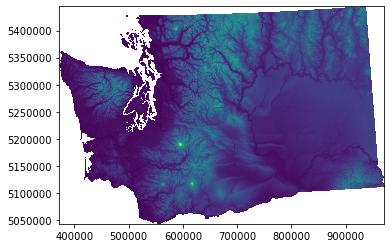

In [52]:
f, ax = plt.subplots()
ax.imshow(wa_ma, extent=wa_ma_extent);

# Lab Exercises

## Create a color shaded relief map
* You should already have the projected, clipped DEM and the hillshade (from unclipped, projected DEM) loaded as arrays
* Create a plot overlaying colored elevation values on the hillshade
    * You have two arrays, both in the same projected coordinate system, but with different extent
    * It's important to correctly set the imshow `extent` correctly for each of the two arrays, otherwise the won't line up correctly
    * Use imshow `alpha` to set transparency of the DEM
    * Add a colorbar

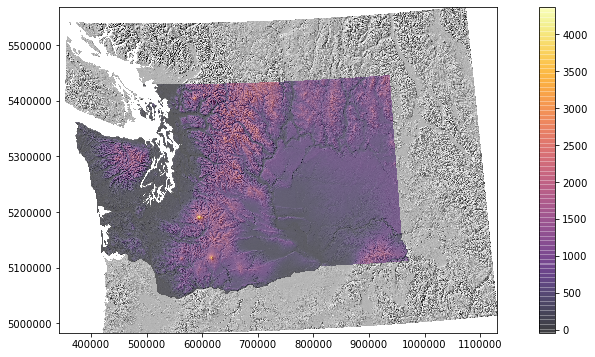

## What is the maximum elevation in WA state (according to SRTM)

## Extra Credit: What percentage of the state is >1 mile above sea level? 
* Sorry about the imperial units, but this is what matters to your average hiking enthusiast
* Remember, that you have a regular grid here, so you know the dimensions in meters of each grid cell
* As we know, this kind of calculation should be done in an equal-area projection, but fine to estimate with UTM projection here

# Volume estimation
* In the Raster1 lab, we computed snow-covered area from a 2D array with known pixel dimensions (30x30 m for Landsat-8)
* Now, let's add a third dimension to compute volume from a 2D array of elevation values
    * Imagine dividing the domain up into 1 cubic meter blocks - your elevation values are like stacks of these 1-m cubes above some reference datum
* Volume (and volume change) calculations are common operations with gridded DEMs.  For example:
    * Measuring quarry slag pile volume
    * Measuring ice sheet and glacier change
* Let's start with a simple example

## Compute the volume of Whidbey Island above sea level
* First, we need an area over which to compute volume
* Extract the Whidbey Island polygon from the WA state geometry

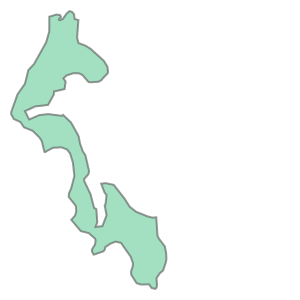

In [63]:
#If using the 500k state outlines, Whidbey is at index 7 in the MultiPolygon
whidbey_geom = wa_geom[7]
whidbey_geom

In [64]:
#Define a GeoSeries for plotting using GeoPandas
whidbey_gdf = gpd.GeoSeries(whidbey_geom)
whidbey_gdf

0    POLYGON ((535640.328 5348457.490, 535403.340 5...
dtype: geometry

* Now, mask the projected DEM dataset using this geometry
    * Note, `rio.mask.mask` expects an iterable "shape", not a single geometry, so need to create and pass a single-element list object containing the whidbey_geom (something like `[whidbey_geom,]`)
    * Use the same parameters that we used when clipping to the WA state geometry above

* Create a plot to verify that you have a masked array of elevation values, with unmasked values only over the Whidbey polygon

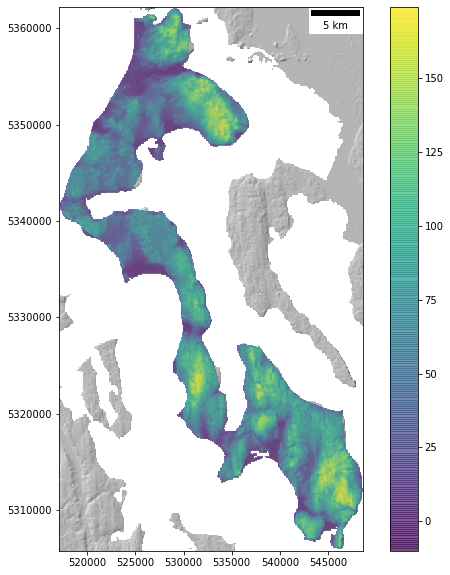

## Define a "bottom" surface for our volume calculation
* Let's use a constant elevation above the geoid (mean sea level) as our "baseline" elevation
    * Since our DEM values are height above the EGM96 geoid, we can use 0 here
    * Note that this bottom surface can also be more complex: a planar fit to elevations around a polygon, lake bathymetry, etc.

## Compute the volume
* Compute the height of the DEM above this "baseline" elevation
* Convert the total volume to km^3
    * One approach: Use the known pixel size (remember to use `res` values from projected dataset) to compute the area of each pixel in m^2, then multiply by the height in m
    * Another: determine mean height above the "baseline" elevation and multiply by total polygon area
* Try to do a sanity check here

In [72]:
#Compute volume as sum of all valid elevations above 0

28.548846932690914

In [73]:
#Compute volume as mean elevation * area

29.423773212262716

## We're gonna need a bigger boat...
* Sea level rise is very real
    * Current global average rates are ~3.6 mm/yr
    * This may not sound like much, but over 100 years, thats 36 cm or ~1.2 feet! And the rate is increasing nonlinearly.
    * Some good references:
        * https://www.ipcc.ch/srocc/chapter/chapter-4-sea-level-rise-and-implications-for-low-lying-islands-coasts-and-communities/
        * https://archive.ipcc.ch/publications_and_data/ar4/wg1/en/faq-5-1.html
        * https://www.ipcc.ch/site/assets/uploads/2018/02/WG1AR5_Chapter13_FINAL.pdf
        * http://www.antarcticglaciers.org/glaciers-and-climate/what-is-the-global-volume-of-land-ice-and-how-is-it-changing/
* Let's do some rough inundation calculations using our DEM
    * Note that in practice, we wouldn't use SRTM for this, but would use a very accurate airborne lidar datset (like the 2016 lidar data available on the WA lidar portal)
    * There are many other caveats here, as sea level rise is much more complex than just "filling the bathtub" (see the IPCC report), but we're learning concepts and techniques, so let's start with a simple case.

### Create a function to compute the area and volume of whidbey island above sea level for:
* 1 meter of sea level rise
* 10 meters of sea level rise
* 20 meters of sea level rise
* 66 meters of sea level rise (roughly the total if all land ice melted, without accounting for thermal expansion)

### Add a visualization component to your function
* Create plots using the whidbey Polygon as "reference shoreline", and plot valid DEM values above the sea level with shared color ramp limits

In [96]:
slr_values = (1,10,20,66)

## Extra Credit: Create area and volume inundation curves
* Starting with sea level of 0, increase by 1 m increments until Whidbey is totally submerged
* Create plots for:
    * exposed area vs sea level
    * exposed volume vs sea level
* Are the curves linear?  

# Sampling a raster at points

Say you have some point data (e.g., lat/lon of field sites) and you need elevation values for your anlysis.  Do you need to go back out and collect new GPS positions?  No!  You can extract elevation values from an existing DEM!

This is a surprisingly common requirement, though it is not always simple to implement.  Let's discuss a few options:
1. Simple `rasterio` sampling with integer indices using nearest neighbor
2. Statistics extracted for a circular buffer around each point location (e.g., median within 90 m radius)
3. NumPy array indices, affine/geotransform between pixel and map coordinates, and NumPy/SciPy interpolation

## Sample the clipped WA SRTM DEM at the WA GLAS points
* Let's start simple, using the rasterio `sample` function, which takes a list of (x,y) tuples in projected coordinates and returns nearest neighbor values from the raster

### Load the GLAS points, reproject and clip to WA state
* We did all of this in previous labs, so I'm including sample code here

In [107]:
glas_fn = '/home/jovyan/01_Shell_Github/GLAH14_tllz_conus_lulcfilt_demfilt.csv'
glas_df = pd.read_csv(glas_fn)
glas_gdf = gpd.GeoDataFrame(glas_df, crs='EPSG:4326', geometry=gpd.points_from_xy(glas_df['lon'], glas_df['lat']))

In [108]:
#Reproject to match our raster crs
glas_gdf_utm = glas_gdf.to_crs(src_proj.crs)

In [109]:
#Return points that intersect WA state geometry
glas_gdf_utm_wa = glas_gdf_utm.loc[glas_gdf_utm.intersects(wa_geom)]

In [110]:
glas_gdf_utm_wa.describe()

decyear        ordinal          lat          lon       glas_z  \
count  5298.000000    5298.000000  5298.000000  5298.000000  5298.000000   
mean   2005.853797  732258.465601    47.431716  -122.300085  1216.463766   
std       1.596727     583.216198     0.940885     1.084877   856.526162   
min    2003.143756  731268.470838    45.547406  -124.468270   -25.700000   
25%    2004.542527  731779.564910    46.408315  -123.265750   161.025000   
50%    2005.814168  732244.171239    47.538272  -122.190471  1518.995000   
75%    2007.201366  732750.498762    48.174146  -121.590553  1869.002500   
max    2009.771999  733689.779543    48.999727  -117.044074  3913.040000   

             dem_z    dem_z_std         lulc  
count  5298.000000  5298.000000  5298.000000  
mean   1214.455789     8.938320    28.607965  
std     858.620242     8.354808     6.303517  
min     -24.120000     0.000000    12.000000  
25%     146.457500     1.842500    31.000000  
50%    1521.535000     7.075000    31.000000  
75%    1865.105000    13.630000    31.000000  
max    3921.140000    49.900000    31.000000

### Prepare the coordinate arrays to pass to rio `sample` function
* The `sample` function expects a list of (x,y) tuples: https://rasterio.readthedocs.io/en/latest/api/rasterio.sample.html
    * Need to create this from the `geometry` objects in your GeoDataFrame
    * Hint: Use list comprehension!
    * You want a list of the form [(x1,y1),(x2,y2),…]
* Pass to `sample`
* Note that the `sample` function returns a `generator` object, and it doesn't actually evaluate the call!
* Can wrap this in a `np.array(list())` to evaluate, or use `np.fromiter()`
* This operation may take ~10-20 seconds to complete

### Deal with nodata
* Some of our GLAS points are located over areas where we don't have valid DEM pixels
* These will have the raster nodata value (-32768 in this case)
* Set these to `np.nan`

## Store the sampled elevation values as a new column in the `glas_gdf_utm_wa` GeoDataFrame

In [116]:
glas_gdf_utm_wa.head()

decyear        ordinal        lat         lon  glas_z  dem_z  \
467  2003.143756  731268.470838  46.291775 -124.037745  -23.44 -23.53   
468  2003.143756  731268.470838  46.293329 -124.038072  -23.11 -23.54   
469  2003.143756  731268.470838  46.294880 -124.038399  -23.98 -22.78   
470  2003.143756  731268.470840  46.302568 -124.040034  -24.61 -23.72   
471  2003.143756  731268.470840  46.304107 -124.040358  -23.92 -23.73   

     dem_z_std  lulc                        geometry  srtm_rio_sample  
467       0.00    31  POINT (420068.610 5126989.811)              NaN  
468       0.00    31  POINT (420045.685 5127162.809)              NaN  
469       0.26    31  POINT (420022.757 5127335.473)              NaN  
470       0.11    31  POINT (419908.041 5128191.352)              NaN  
471       0.00    31  POINT (419885.336 5128362.681)              1.0

### Create a plot of your new sampled elevation values
* Can visualize over shaded relief map, and/or use `edgecolor='white'` over the DEM with same color stretch for elevation values

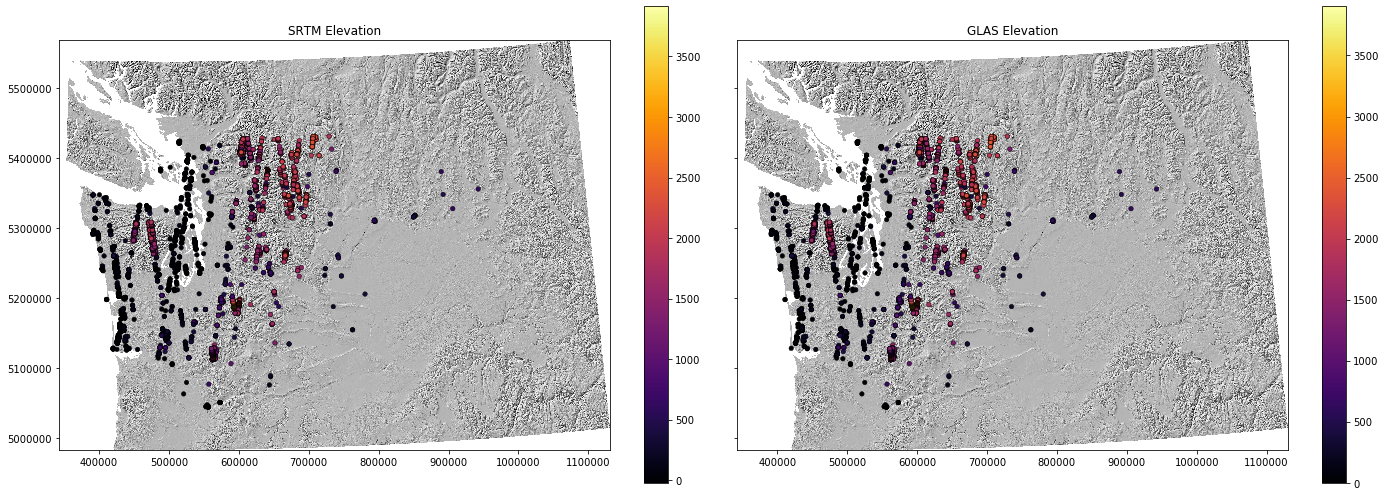

## Extra Credit: Compare sampled SRTM elevation with the GLAS elevation (`glas_z`)

#### What is median offset?
* Think back to Lab03 where we learned about datums and elevations reported as height above ellipsoid vs. height above geoid (mean sea level)

In [120]:
glas_gdf_utm_wa['glas_srtm_diff'].describe()

count    4734.000000
mean      -23.805467
std        31.246637
min      -295.960000
25%       -36.080000
50%       -22.840000
75%       -10.500000
max       248.530000
Name: glas_srtm_diff, dtype: float64

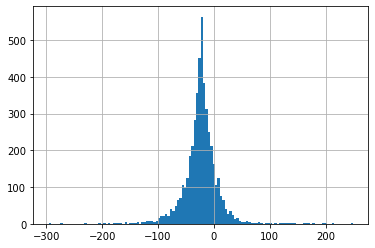

In [121]:
glas_gdf_utm_wa['glas_srtm_diff'].hist(bins=128)

#### Remove EGM96 geoid offset from the SRTM samples and compare again

In [122]:
#From PROJ7 cloud-hosted datum grids: https://cdn.proj.org/
url = 'https://cdn.proj.org/us_nga_egm96_15.tif'

In [123]:
src_egm96 = rio.open(url)
src_egm96.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1440, 'height': 721, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.25, 0.0, -180.125,
       0.0, -0.25, 90.125), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

In [124]:
egm96 = src_egm96.read(1)
egm96_extent = rio.plot.plotting_extent(src_egm96)
np.percentile(egm96, (2,98))

array([-60.25124443,  59.33671082])

In [125]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [126]:
clim = (-60,60)
#Contour interval
cint = 10
clevels=np.arange(np.floor(egm96.min()/cint)*cint, np.ceil(egm96.max()/cint)*cint, cint)

In [127]:
#This function is defined later in the notebook
egm96_hs,_,_ = hillshade(egm96)

Text(0.5, 1, 'EGM96 Geoid Offset Relative to WGS84 Ellipsoid')

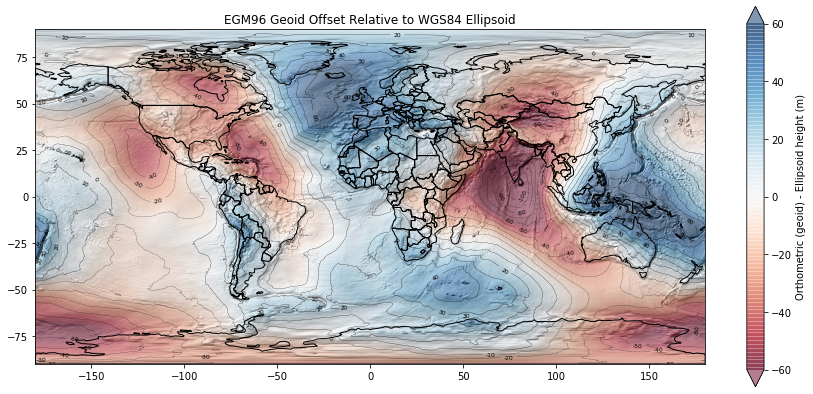

In [128]:
f, ax = plt.subplots(figsize=(15,7))
m = ax.imshow(egm96, extent=egm96_extent, cmap='RdBu', clim=clim, alpha=0.5, zorder=1)
ax.imshow(egm96_hs, cmap='gray', extent=egm96_extent, zorder=0)
ax.autoscale(False)
c_color = 'k'
cs = ax.contour(egm96, origin='image', extent=egm96_extent, linewidths=0.25, alpha=1.0, colors=c_color, levels=clevels)
ax.clabel(cs, inline=1, fmt='%0.0f', colors=c_color, fontsize=6)
world.plot(ax=ax, facecolor='none', lw=1, edgecolor='k', zorder=2)
plt.colorbar(m, label='Orthometric (geoid) - Ellipsoid height (m)', extend='both');
ax.set_title('EGM96 Geoid Offset Relative to WGS84 Ellipsoid')

TODO: warp egm96 offset grid to match the reprojected SRTM grid, then sample

### Notes on sampling coarse rasters or noisy rasters at integer pixel locations
* The rasterio approach is efficient, but it uses "nearest neighbor" approach to extract the elevation value for the grid cell that contains the point, regradless of where the point falls within the grid cell (center vs. corner)
* But our grid cells can be big (~90x90 m for the SRTM3 data), so if point is near the corner of a pixel on steep slope, the pixel value it might not be representative.
* A better approach is to use bilinear or bicubic sampling, to interpolate the elevation value at the point coordinate using pixel values within some neighborhood around the point, (e.g. 2x2 window for bilinear, 4x4 window for cubic)
* Other approaches using stats for raster values within some radius of the point location (e.g., median elevation of pixels within 300 m of the point)
    * https://www.earthdatascience.org/courses/earth-analytics-python/lidar-remote-sensing-uncertainty/extract-data-from-raster/
    * https://pysal.org/scipy2019-intermediate-gds/deterministic/gds2-rasters.html#getting-values-at-cells
    * https://github.com/dshean/pygeotools/blob/master/pygeotools/lib/geolib.py#L1019

### Extra Credit: Compute stats for each GLAS point using buffer with width of 3x the DEM resolution (in meters) and compare with the nearest neighbor values from rasterio `sample` above

In [137]:
buff_width = src_proj.res[0]*3
buff_width

209.27331930542232

In [138]:
#Create new GeoDataSeries of buffered polygons
glas_gdf_utm_wa_buff = glas_gdf_utm_wa.buffer(buff_width)
glas_gdf_utm_wa_buff

467      POLYGON ((420277.883 5126989.811, 420276.875 5...
468      POLYGON ((420254.958 5127162.809, 420253.950 5...
469      POLYGON ((420232.030 5127335.473, 420231.022 5...
470      POLYGON ((420117.314 5128191.352, 420116.307 5...
471      POLYGON ((420094.609 5128362.681, 420093.601 5...
                               ...                        
65068    POLYGON ((426381.259 5138031.192, 426380.251 5...
65069    POLYGON ((426353.876 5137859.495, 426352.868 5...
65070    POLYGON ((426298.722 5137516.106, 426297.714 5...
65071    POLYGON ((426271.027 5137344.413, 426270.020 5...
65072    POLYGON ((426243.330 5137172.610, 426242.322 5...
Length: 5298, dtype: geometry

In [140]:
#Define relevant stats for our sampling
stats=['count', 'min', 'max', 'median', 'std']

In [141]:
#Compute zonal stats for buffered circles around each point using rasterstats
#https://pythonhosted.org/rasterstats/rasterstats.html
glas_zonal_stats = rasterstats.zonal_stats(glas_gdf_utm_wa_buff, wa_ma, \
                                           affine=wa_ma_transform, nodata=src_proj.nodata, stats=stats)

In [142]:
glas_zonal_stats[0:5]

[{'count': 0, 'min': None, 'max': None, 'median': None, 'std': None},
 {'count': 0, 'min': None, 'max': None, 'median': None, 'std': None},
 {'count': 0, 'min': None, 'max': None, 'median': None, 'std': None},
 {'min': 1.0,
  'max': 5.0,
  'count': 7,
  'std': 1.4142135623730951,
  'median': 1.0},
 {'min': 0.0,
  'max': 16.0,
  'count': 19,
  'std': 4.212499537634471,
  'median': 1.0}]

### Extra Credit: Do the GLAS points provide a good sample of the observed WA state hypsometry?
* Hypsometry is just total area in different elevation bins (https://en.wikipedia.org/wiki/Hypsometry)
* Plot histogram for your clipped WA DEM
* Overlay histogram of your glas sites using the same bins

# Let's determine which sections of WA highways are surrounded by the steepest slopes
* Requires sampling a derived DEM product (slope) around Polyline objects (highways)
* This is important for geohazards (rockfall, avalanches)
* You can probably make an informed guess here based on knowledge of the terrain and WA highway network
* Note that in practice, you would want to higher resolution DEM with higher accuracy (e.g., DTM from airborne lidar), but same concept/method applies

## Compute surface slope
* Easy to use `gdaldem` command again here (like hillshade generation above)
* Can also compute slope directly from our DEM array

In [149]:
slope_fn = os.path.splitext(proj_fn)[0]+'_slope.tif'

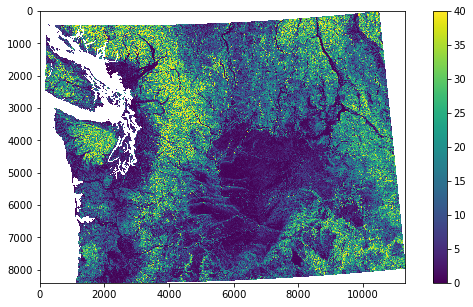

## Prepare highway data

In [153]:
#Grab the WA DOT highway data
wa_dot_highway_url = 'https://www.wsdot.wa.gov/mapsdata/geodatacatalog/maps/NOSCALE/DOT_TDO/LRS/500KLRS_2018.zip'
!wget -nc $wa_dot_highway_url

File ‘500KLRS_2018.zip’ already there; not retrieving.



In [154]:
#Unzip
wa_dot_highway_zip_fn = os.path.split(wa_dot_highway_url)[-1]
!unzip -n $wa_dot_highway_zip_fn

Archive:  500KLRS_2018.zip


In [126]:
#Load as GeoDataFrame and reproject
wa_dot_highway_shp_fn = '500k/sr500klines_20181231.shp'
highways_gdf = gpd.read_file(wa_dot_highway_shp_fn)
highways_gdf_utm = highways_gdf.to_crs(src_proj.crs)

In [127]:
highways_gdf_utm.describe()

BARM         EARM     RT_TYPEB     SHAPE_Leng
count  1044.000000  1044.000000  1044.000000    1044.000000
mean     59.956398    66.752126     0.720307   35699.117610
std      92.223740    93.549924     1.171051   45582.915523
min       0.000000     0.010000     0.000000      22.339343
25%       0.000000     5.377500     0.000000    4006.665922
50%      15.100000    24.290000     0.000000   18152.453080
75%      78.032500    85.017500     1.000000   48173.674294
max     430.730000   436.130000     6.000000  301583.554065

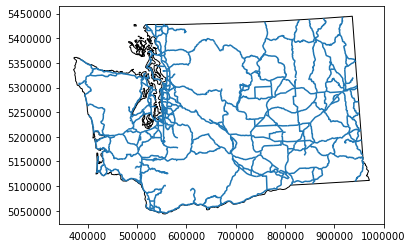

In [128]:
f, ax = plt.subplots()
wa_state.plot(ax=ax, facecolor='none', edgecolor='k')
highways_gdf_utm.plot(ax=ax);

## Evaluate slopes within a 100 m buffer around the polylines
* Remember that the output of `buffer` is a GeoSeries of Polygons - want to create a new GeoDataFrame and use this as the `geometry`

## Now use `zonal_stats` to compute slope statistics
* See the `rasterstats` documentation: https://pythonhosted.org/rasterstats/manual.html#zonal-statistics
* The docs example uses a shapefile on disk and raster on disk, but we already have our features and raster loaded in memory!
    * Can pass in the GeoDataFrame containing buffered Polygon features instead of a filename
    * Can pass in the slope NumPy array instead of the raster filename, but need to provide the appropriate rasterio dataset `transform` to the `affine` keyword
        * Should also pass the appropriate rasterio dataset `nodata` value
* Compute stats and add the following columns to the `highways_gdf_utm` geodataframe for each highway segment:
    * mean slope
    * std of slope (a roughness metric)
* Create some plots to visualize
    * If you're plotting the GeoDataFrame containing the original LINESTRING geometry objects, choose an appropriate `linewidth`

min        max       mean  count        std     median
0     0.000000   4.242781   1.579610     48   0.969806   1.403453
1     0.000000   6.805913   1.376496   1939   1.065004   1.056924
2     0.145196   4.512753   1.781780     57   1.057641   1.543083
3     0.145196   5.066543   1.765079    639   0.889025   1.692771
4     0.145196   3.531279   1.311060    203   0.733071   1.105644
...        ...        ...        ...    ...        ...        ...
1039  0.145196   1.655030   0.741421     12   0.423253   0.740317
1040  0.459141   2.157475   1.226988     16   0.555909   0.988377
1041  0.000000   3.288209   1.103647    132   0.565638   1.026582
1042  0.000000  14.671628   4.082529    514   3.466671   2.775551
1043  0.145196  47.420250  13.754264    956  10.145538  11.737300

[1044 rows x 6 columns]

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


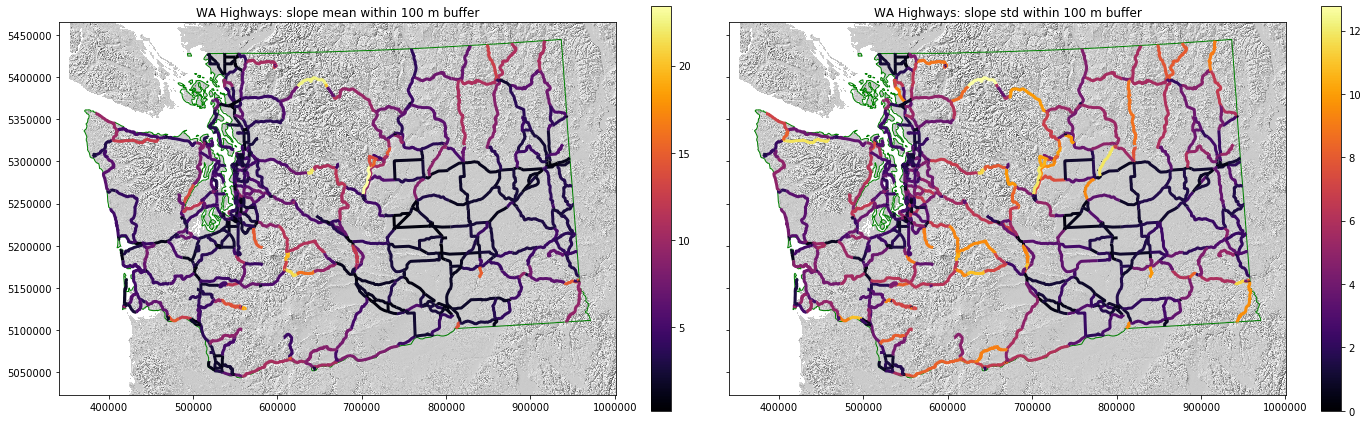

## Question: which section of the highway might you close first during periods of extreme winter weather?

### Extra Credit:
1. Compute zonal stats for the elevation values (not slope values)
    * Which highway sections cover the greatest elevation range?
2. Compute the slope _along_ the highway polylines, not zonal stats for slope of surrounding terrain
    * Probably want to sample your DEM at points here and compute rise (elevation change) over run (distance between points)
3. Repeat some of the above analysis for WA rivers or watersheds

## Extra Credit: Raster Filtering
* Applying digital filters is a common operation in image processing
* Can be useful to filter outliers, reduce noise, find edges, etc.
* Lots of useful kernel-based filters in `scipy.ndimage`: https://docs.scipy.org/doc/scipy/reference/ndimage.html
    * Note that many of these do not elegantly handle NaN or masked values!

### Extract a portion of the DEM around Mt Rainier

In [139]:
#From Raster1 lab
window_bounds = (581385.0, 5174595.0, 612105.0, 5205315.0)
print("Window bounds: ", window_bounds)
window_extent = [window_bounds[0], window_bounds[2], window_bounds[1], window_bounds[3]]
print("Window extent: ", window_extent)

Window bounds:  (581385.0, 5174595.0, 612105.0, 5205315.0)
Window extent:  [581385.0, 612105.0, 5174595.0, 5205315.0]


In [140]:
rainier_window = rio.windows.from_bounds(*window_bounds, transform=src_proj.transform)
rainier_window

Window(col_off=3426.3656952053316, row_off=5218.799368306427, width=440.3810304432445, height=440.3810304432409)

In [141]:
rainier_ma = src_proj.read(1, window=rainier_window)
#rainier_ma = np.ma.masked_equal(rainier_ma, src_proj.nodata)

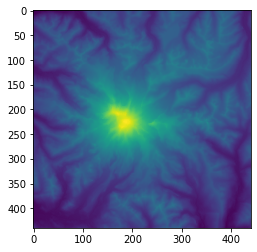

In [142]:
plt.imshow(rainier_ma)

In [143]:
rainier_hs, slope, aspect = hillshade(rainier_ma, src_proj.res[0])
print(slope.max(), aspect.max())

68.85719641554101 179.67071753615335


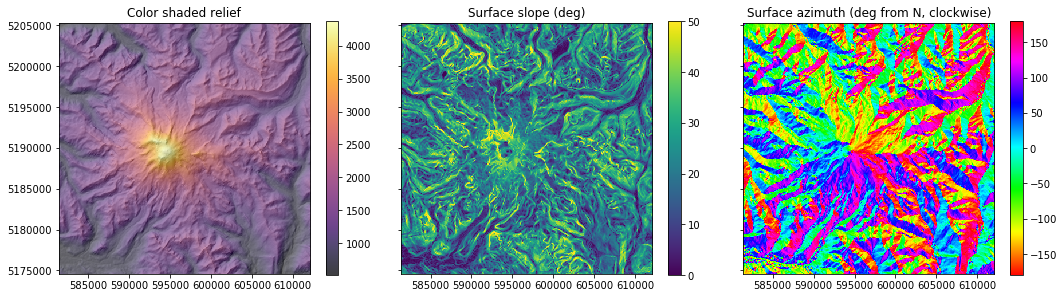

## Gaussian smoothing

In [145]:
from scipy.ndimage import gaussian_filter
#This controls width of gaussian kernel standard deviation in pixels
#Play around with a few values
sigma = 3

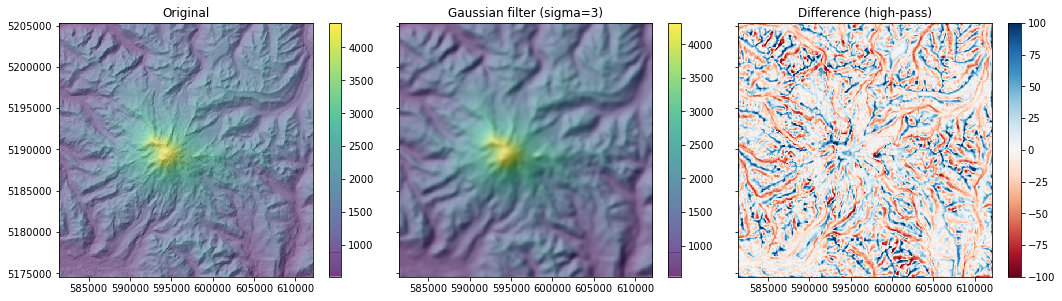

## Extra Credit: explore some hydrologic functions with RichDEM
* https://github.com/r-barnes/richdem